In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "arm64/"
files = os.listdir(path)
len(files)

7273

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
#path = "arm64/"

def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [5]:
sample_code_dict = extract_code(path, sample_files)

In [6]:
len(sample_code_dict.keys())

100

In [7]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

478752d86b7fac6b7d330c4fe5a64f9f	136748	[255, 67, 14, 209, 253, 123, 182, 169, 253, 3]
3c9c76b4e6c349f4abb3b542717d75df	67144	[253, 123, 190, 169, 253, 3, 0, 145, 243, 83]
c7c7b8bd0da51ead07ba55449922dc9c	49668	[253, 123, 185, 169, 228, 0, 0, 208, 227, 0]
fed2a81dafaa381e3ff52ebf9fd2ed9f	234472	[253, 123, 189, 169, 3, 2, 0, 144, 253, 3]
a98f6c0308baab60e2fac5f8367480eb	27968	[253, 123, 191, 169, 253, 3, 0, 145, 94, 0]
c9aea21c5f7e80ef2d7877351fb330a5	29716	[253, 123, 173, 169, 253, 3, 0, 145, 232, 39]
6dbd82ad8ff92370e49676514612c9ab	1106052	[255, 131, 10, 209, 195, 10, 0, 176, 99, 0]
af70d1678a14eea7bf65251a079b34b6	41676	[253, 123, 186, 169, 98, 0, 0, 176, 253, 3]
57d82c476ea27a928e75752e64a81a96	61556	[253, 123, 191, 169, 253, 3, 0, 145, 118, 255]
325737caa4e18df2d72dfe913017ce02	70604	[253, 123, 172, 169, 253, 3, 0, 145, 243, 83]
7a59a0dc4eeaa911a6863bc958d856f0	13116	[253, 123, 189, 169, 162, 0, 0, 144, 253, 3]
a4733467189b57b76fb374efdb92bab8	12388	[253, 123, 186, 169, 253, 3, 0,

In [8]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

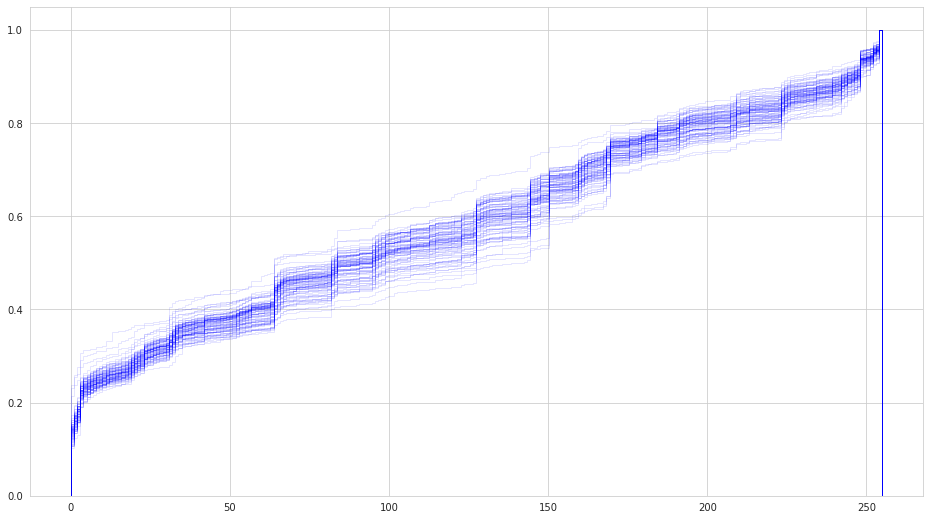

In [9]:
plot_dists(sample_code_dict)

In [10]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [11]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [12]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:50<00:00, 19.97it/s]


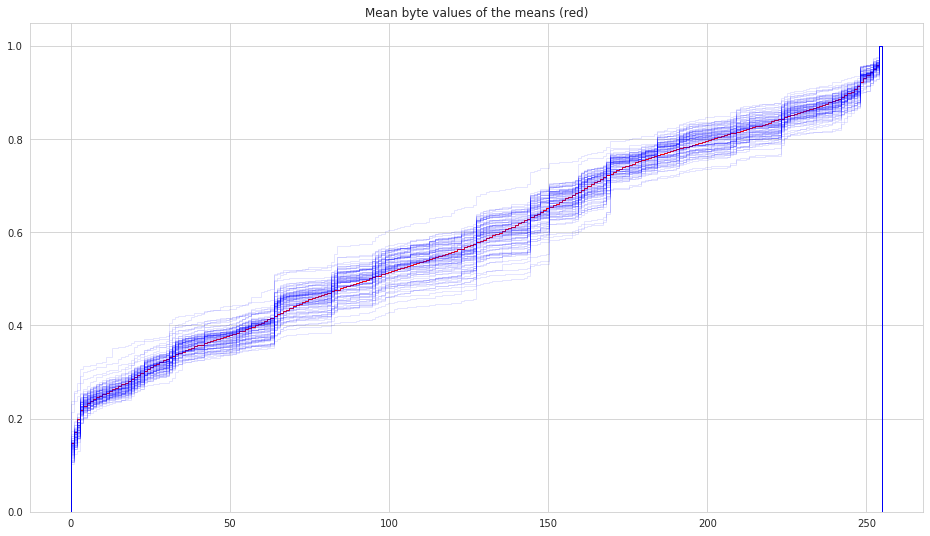

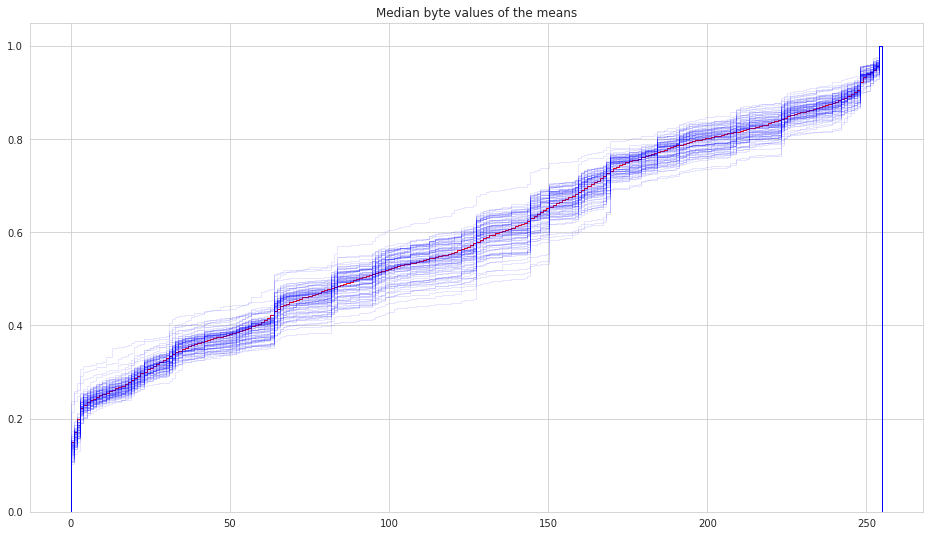

In [13]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

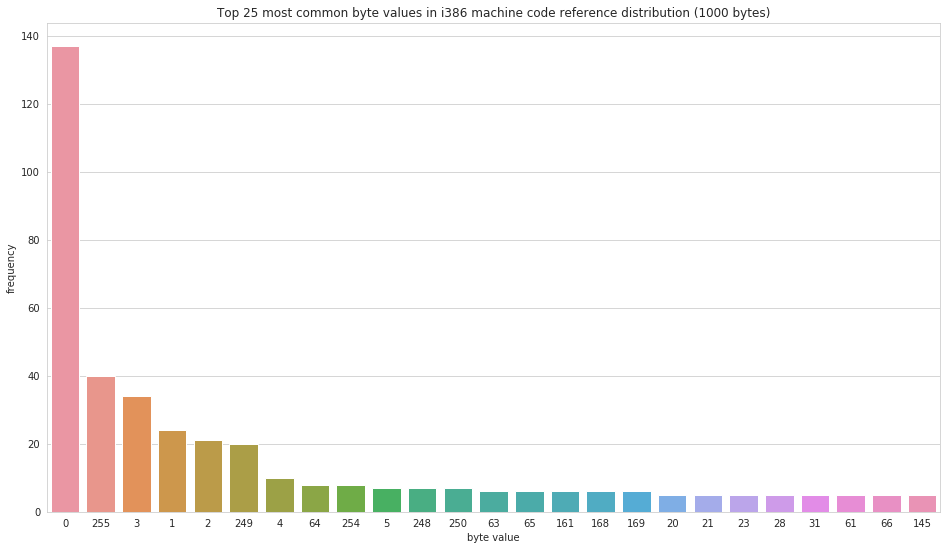

In [14]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in i386 machine code reference distribution (1000 bytes)")
plt.show()

In [15]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xff',
 '0x3',
 '0x1',
 '0x2',
 '0xf9',
 '0x4',
 '0x40',
 '0xfe',
 '0x5',
 '0xf8',
 '0xfa',
 '0x3f',
 '0x41',
 '0xa1',
 '0xa8',
 '0xa9',
 '0x14',
 '0x15',
 '0x17',
 '0x1c',
 '0x1f',
 '0x3d',
 '0x42',
 '0x91']

In [18]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [19]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [21]:
test_code_dict = extract_code(path, test_files, n_files=1000)

In [22]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

6a35f6252a2026f04923b0472953c354	112960	[4, 2, 0, 176, 33, 1, 0, 208, 253, 123]
4dc70ba3d84a4dd6fd2e2b32a02ff61c	116512	[2, 2, 0, 88, 226, 0, 0, 180, 3, 64]
0a32cc9e9b942528ade4a726d66ef0dd	36012	[228, 0, 0, 176, 65, 0, 0, 176, 253, 123]
a69863a9acce14f56d7098ed6d3eccad	35496	[253, 123, 174, 169, 253, 3, 0, 145, 243, 83]
992e32de3e8600d118c50cd471cc0093	185060	[2, 2, 0, 88, 226, 0, 0, 180, 3, 64]
e22f308b197717085fdc9da611a23096	62884	[253, 123, 191, 169, 253, 3, 0, 145, 118, 255]
ca66adc1ad69a77a96d6dfa7457689d2	15324	[253, 123, 183, 169, 253, 3, 0, 145, 249, 107]
73e9a43350bfa1bfcc78933aa073fb1c	115272	[255, 131, 32, 209, 226, 0, 0, 176, 68, 64]
424ae79750a5d302b74223a86967fbdd	12616	[162, 0, 0, 144, 4, 0, 128, 210, 3, 45]
b508913bd03c68b1bf2792cd88faf714	30228	[253, 123, 167, 169, 227, 0, 0, 144, 253, 3]
e93d4aa09992586dd5e0c24c9b2c3763	38236	[255, 3, 2, 209, 253, 123, 1, 169, 253, 67]
51c89aa4b973da81d03d6f00e58d3431	111096	[253, 123, 191, 169, 227, 0, 0, 144, 225, 0]
8c941e2417399

In [23]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(817, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
6a35f6252a2026f04923b0472953c354,112960,1.97636,0.222917,106.147,96,90.0895
4dc70ba3d84a4dd6fd2e2b32a02ff61c,116512,5.53429,0.531377,110.01,98,90.7364
0a32cc9e9b942528ade4a726d66ef0dd,36012,3.14934,0.328542,107.401,96,91.0501
a69863a9acce14f56d7098ed6d3eccad,35496,7.37561,0.695056,111.877,101,92.555
992e32de3e8600d118c50cd471cc0093,185060,10.1525,0.969971,114.661,123,91.464
...,...,...,...,...,...,...
0542614376e54880ad8ae2881bbfa698,576440,2.49972,0.268026,104.821,95,88.2745
1995d006e1f80f42318322c3f2e53ed6,436812,6.7704,0.65348,111.261,98,92.7023
9077e0bb5a73b8c656dcc9f24b4653bf,54908,2.32382,0.262378,102.476,84,89.6511
80adc5701f185c078c3ec1fa620515a9,14864,2.81097,0.280047,103.41,84,91.2531


In [24]:
test_results_df.mean()

size                    147617.507956
wasserstein distance         5.360012
energy distance              0.537684
mean                       104.921123
median                      93.611383
standard deviation          89.728862
dtype: float64

In [25]:
test_results_df.median()

size                    51164.000000
wasserstein distance        4.229476
energy distance             0.441357
mean                      105.006558
median                     95.000000
standard deviation         90.129600
dtype: float64

In [26]:
test_results_df["size"].sum()

120603504

In [27]:
test_results_df["size"].sum() / 1000000

120.603504

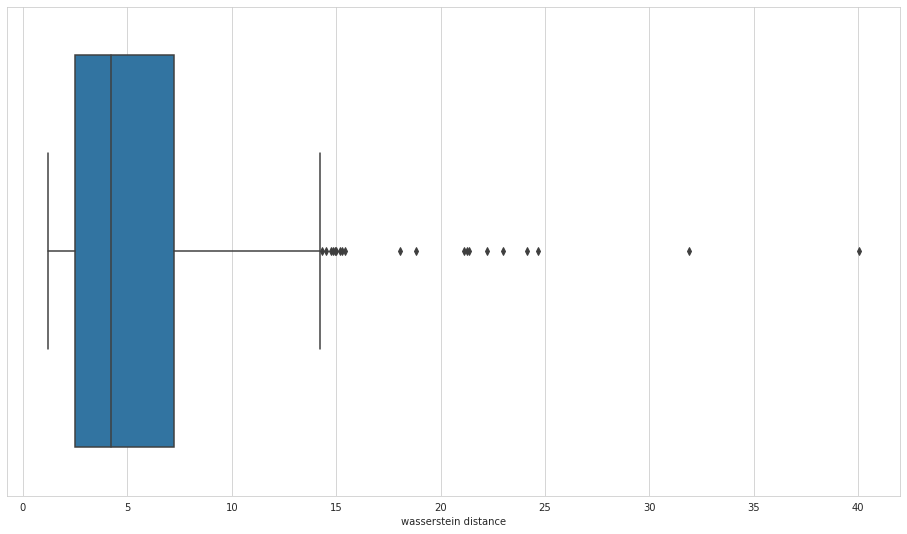

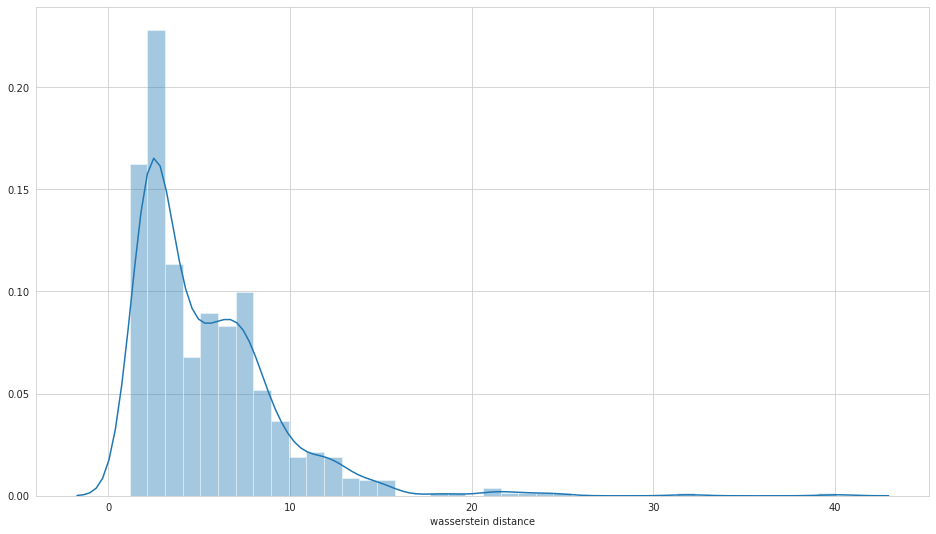

In [28]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

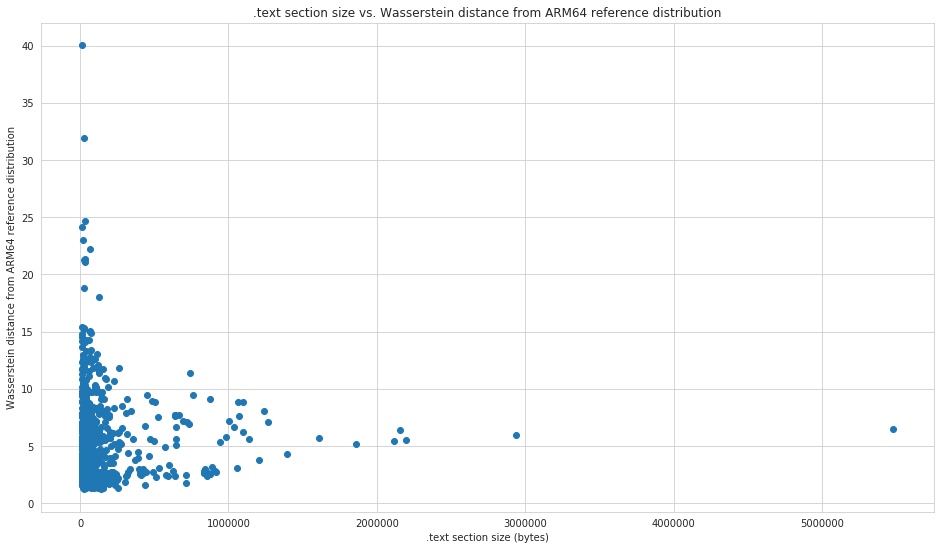

In [29]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from ARM64 reference distribution")
plt.title(".text section size vs. Wasserstein distance from ARM64 reference distribution")
plt.show()

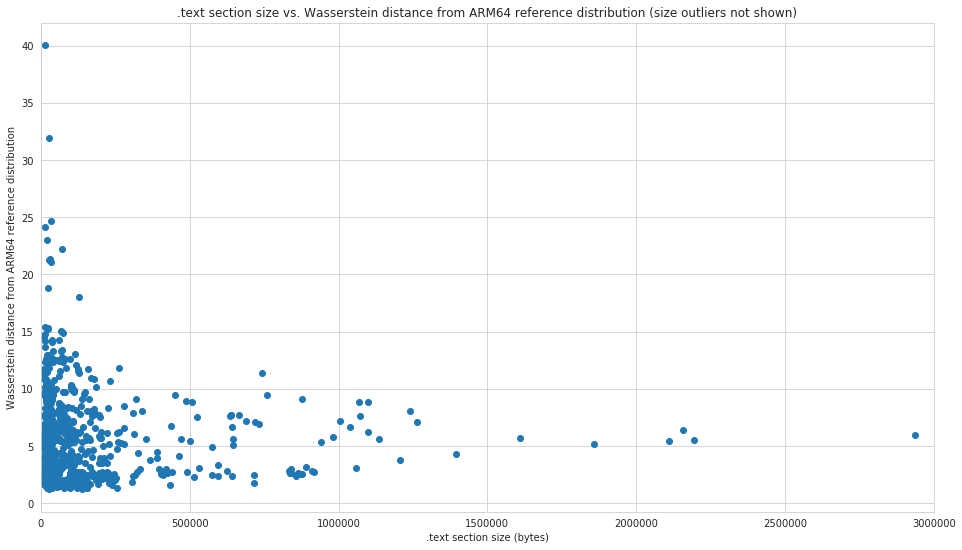

In [31]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from ARM64 reference distribution")
plt.title(".text section size vs. Wasserstein distance from ARM64 reference distribution (size outliers not shown)")
plt.xlim(0, 3000000)
plt.show()

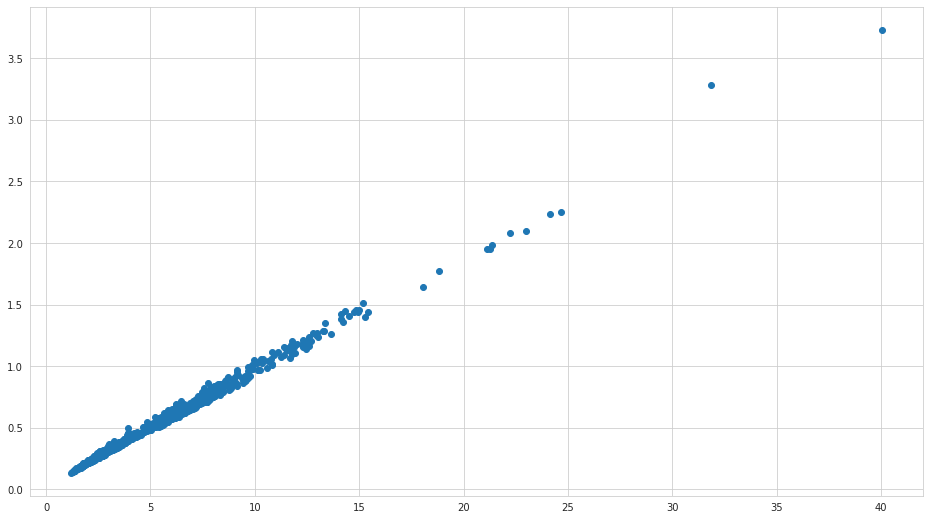

In [32]:
plt.scatter(test_results_df["wasserstein distance"], test_results_df["energy distance"])

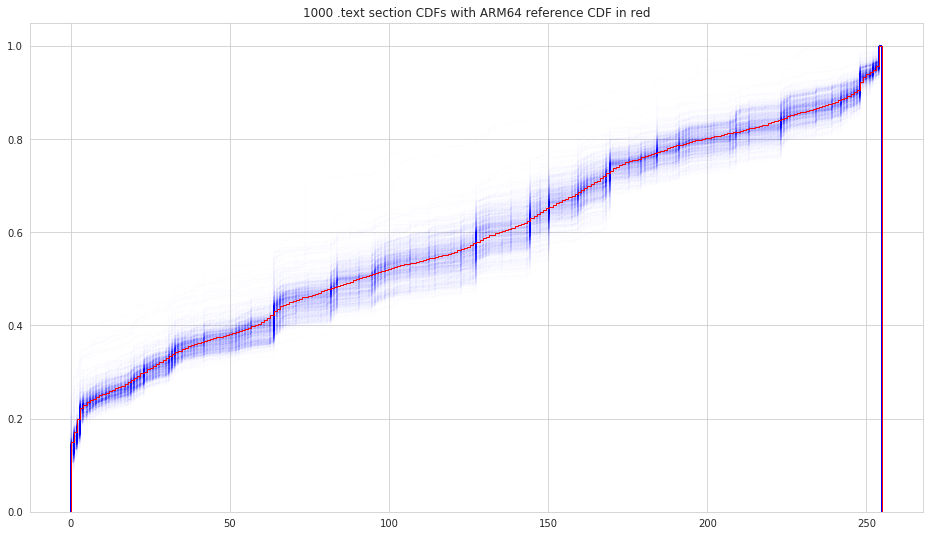

In [35]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with ARM64 reference CDF in red")
plt.show()

In [34]:
# export reference distribution
with open("ARM64_reference", "wb") as f:
    pickle.dump(median, f)